In [1]:
# autoreload python modules on the fly when its source is changed
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from __future__ import division


import requests
import bs4
import pandas as pd
import numpy as np
import time
import re
import traceback
import pickle
from os.path import exists, isfile, join
from optparse import OptionParser
import os
import json
from collections import OrderedDict
import codecs
from IPython.core.display import display, HTML, Markdown
import py_d3
py_d3.load_ipython_extension(get_ipython())
import seaborn as sns

import treelib
from treelib import Node, Tree
import mistune

import utils

## Статистика

In [2]:
df = pd.read_csv('main_topics.csv')
df

,href,id,title
0,https://glav.su/forum/3/,3,ЭКОНОМИЧЕСКИЙ РАЗДЕЛ
1,https://glav.su/forum/4/,4,ПОЛИТИЧЕСКИЙ РАЗДЕЛ
2,https://glav.su/forum/5/,5,ВОЕННЫЙ РАЗДЕЛ
3,https://glav.su/forum/2/,2,НАУЧНО-ТЕХНИЧЕСКИЙ РАЗДЕЛ
4,https://glav.su/forum/13/,13,ИСТОРИЧЕСКИЙ РАЗДЕЛ
5,https://glav.su/forum/12/,12,АВТОРСКИЙ РАЗДЕЛ
6,https://glav.su/forum/1/,1,ПОЛЬЗОВАТЕЛЬСКИЙ РАЗДЕЛ
7,https://glav.su/forum/7/,7,ТЕХНИЧЕСКИЙ РАЗДЕЛ


In [3]:
df_topics = pd.read_csv('topics_all.csv', parse_dates=['datetime'])
print(len(df_topics))

1596


In [4]:
df_topics.head()

,author_id,author_name,href,is_blocked,is_bold,last_datetime,main_tid,tid,title,datetime,tag1,tag2,tag3
0,20829,Osq,https://glav.su/forum/3/8/,False,True,Вчера в 21:54,3,8,Мировой экономический кризис,2017-12-17 21:54:00,NaN,NaN,NaN
1,40326,AGROVID.COM,https://glav.su/forum/3/15/,False,True,03.12.17 10:06,3,15,Рынок недвижимости: состояние и перспективы,2017-03-12 10:06:00,NaN,NaN,NaN
2,40321,Nokia22,https://glav.su/forum/3/2452/,False,True,01.12.17 16:50,3,2452,Санкции в отношении России,2017-01-12 16:50:00,NaN,NaN,NaN
3,40073,Брустер,https://glav.su/forum/3/777/,False,True,01.12.17 12:44,3,777,Социология и этика кризиса,2017-01-12 12:44:00,NaN,NaN,NaN
4,18333,Борменталь,https://glav.su/forum/3/206/,False,True,09.09.17 14:09,3,206,FAQ или сборник основных идей,2017-09-09 14:09:00,NaN,NaN,NaN


/home/.virtualenvs/drivers2/local/lib/python2.7/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


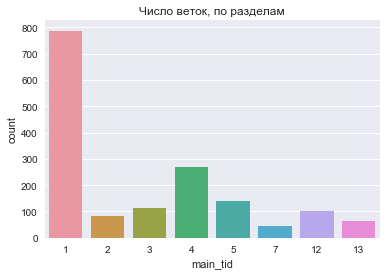

In [5]:
ax = sns.countplot(x='main_tid', data=df_topics)
ax.set_title(u'Число веток, по разделам')
pass

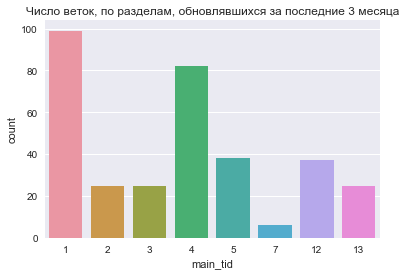

In [6]:
mask = (df_topics['datetime'] > '2017-09-01') & (df_topics['datetime'] <= '2017-12-31')
ax = sns.countplot(x='main_tid', data=df_topics.loc[mask])
ax.set_title(u'Число веток, по разделам, обновлявшихся за последние 3 месяца')
pass

## Проверка соответвия тэгов

Проверка что все тэги, которые прикреплены к веткам, есть в файле описаний дерева категорий.

In [66]:
with codecs.open('tree.md', 'r', 'utf-8') as f:
    tree_md = f.read()
Markdown(tree_md)


- [ПОЛИТИЧЕСКИЙ РАЗДЕЛ](https://glav.su/forum/4/)
  - Геополитика
    - Россия
      - Кавказ
      - Крым
      - Москва
      - Оппозиция
    - Украина
      - Донбасс
      - Янукович
    - Постсоветское пространство
      - Абхазия
      - Армения
      - Азербайджан
      - Белоруссия
      - Грузия
      - Казахстан
      - Киргизия
      - Молдавия
      - Приднестровье
      - Туркмения
    - Ближний восток
      - Иран
      - Курды
      - Сирия
      - Турция
    - Европа
      - Болгария
      - Великобритания
      - Германия
      - Испания
      - Македония
      - Новороссия
      - Польша
      - Сербия
      - Франция
    - США
    - Другие страны
      - Венесуэла
      - Вьетнам
      - Египет
      - Израиль
      - Индия
      - Ирак
      - Китай
      - КНДР
      - Куба
      - Ливия
      - Пакистан
      - Шотландия
      - Япония
    - БРИКС
    - ООН
  - Общие вопросы, теория
    - Инфраструктура
  - Вооружение
      - НАТО
  - Происшествия
  - Личности
    - Путин
    - Сталин
    - Ходорковский
  - Санкции
  - Наука
    - Космос
  - Информационные войны
  - Отстойник (и спам)


In [67]:
tree = utils.parse_tree(tree_md)
tree.show()

root
└── ПОЛИТИЧЕСКИЙ РАЗДЕЛ
    ├── Вооружение
    │   └── НАТО
    ├── Геополитика
    │   ├── БРИКС
    │   ├── Ближний восток
    │   │   ├── Иран
    │   │   ├── Курды
    │   │   ├── Сирия
    │   │   └── Турция
    │   ├── Другие страны
    │   │   ├── Венесуэла
    │   │   ├── Вьетнам
    │   │   ├── Египет
    │   │   ├── Израиль
    │   │   ├── Индия
    │   │   ├── Ирак
    │   │   ├── КНДР
    │   │   ├── Китай
    │   │   ├── Куба
    │   │   ├── Ливия
    │   │   ├── Пакистан
    │   │   ├── Шотландия
    │   │   └── Япония
    │   ├── Европа
    │   │   ├── Болгария
    │   │   ├── Великобритания
    │   │   ├── Германия
    │   │   ├── Испания
    │   │   ├── Македония
    │   │   ├── Новороссия
    │   │   ├── Польша
    │   │   ├── Сербия
    │   │   └── Франция
    │   ├── ООН
    │   ├── Постсоветское пространство
    │   │   ├── Абхазия
    │   │   ├── Азербайджан
    │   │   ├── Армения
    │   │   ├── Белоруссия
    │   │   ├── Грузия
    │   │   ├── Казахстан
  

In [68]:
df_topics = pd.read_csv('topics_all.csv', parse_dates=['datetime'], encoding='utf8')
#df_topics

In [69]:
print("Уникальные тэги в исходном файле")
for tag in utils.get_unique_tags(df_topics):
    print(tag)

Уникальные тэги в исходном файле
4 Абхазия
4 Азербайджан
4 Армения
4 БРИКС
4 Белоруссия
4 Ближний восток
4 Болгария
4 Великобритания
4 Венесуэла
4 Вооружение
4 Вьетнам
4 Гаямян
4 Германия
4 Грузия
4 Донбасс
4 Другие страны
4 Европа
4 Египет
4 Израиль
4 Индия
4 Информационные войны
4 Инфраструктура
4 Ирак
4 Иран
4 Испания
4 КНДР
4 Кавказ
4 Казахстан
4 Киргизия
4 Китай
4 Космос
4 Крым
4 Куба
4 Курды
4 Ливия
4 Македония
4 Молдавия
4 Москва
4 НАТО
4 Наука
4 Новороссия
4 ООН
4 Общие вопросы, теория
4 Оппозиция
4 Отстойник (и спам)
4 ПОЛИТИЧЕСКИЙ РАЗДЕЛ
4 Пакистан
4 Польша
4 Постсоветское пространство
4 Приднестровье
4 Происшествия
4 Путин
4 Россия
4 США
4 Санкции
4 Сербия
4 Сирия
4 Сталин
4 Туркмения
4 Турция
4 Украина
4 Франция
4 Ходорковский
4 Шотландия
4 Янукович
4 Япония


In [70]:
absents, indices = utils.check_tags(tree, df_topics)

In [71]:
utils.print_absents(absents, indices, df_topics)

## Построение дерева списка тем

### Исходные данные

In [72]:
with codecs.open('tree.md', 'r', 'utf-8') as f:
    tree_md = f.read()
Markdown(tree_md)

- [ПОЛИТИЧЕСКИЙ РАЗДЕЛ](https://glav.su/forum/4/)
  - Геополитика
    - Россия
      - Кавказ
      - Крым
      - Москва
      - Оппозиция
    - Украина
      - Донбасс
      - Янукович
    - Постсоветское пространство
      - Абхазия
      - Армения
      - Азербайджан
      - Белоруссия
      - Грузия
      - Казахстан
      - Киргизия
      - Молдавия
      - Приднестровье
      - Туркмения
    - Ближний восток
      - Иран
      - Курды
      - Сирия
      - Турция
    - Европа
      - Болгария
      - Великобритания
      - Германия
      - Испания
      - Македония
      - Новороссия
      - Польша
      - Сербия
      - Франция
    - США
    - Другие страны
      - Венесуэла
      - Вьетнам
      - Египет
      - Израиль
      - Индия
      - Ирак
      - Китай
      - КНДР
      - Куба
      - Ливия
      - Пакистан
      - Шотландия
      - Япония
    - БРИКС
    - ООН
  - Общие вопросы, теория
    - Инфраструктура
  - Вооружение
      - НАТО
  - Происшествия
  - Личности
    - Путин
    - Сталин
    - Ходорковский
  - Санкции
  - Наука
    - Космос
  - Информационные войны
  - Отстойник (и спам)


In [73]:
tree = utils.parse_tree(tree_md)
tree.show()

root
└── ПОЛИТИЧЕСКИЙ РАЗДЕЛ
    ├── Вооружение
    │   └── НАТО
    ├── Геополитика
    │   ├── БРИКС
    │   ├── Ближний восток
    │   │   ├── Иран
    │   │   ├── Курды
    │   │   ├── Сирия
    │   │   └── Турция
    │   ├── Другие страны
    │   │   ├── Венесуэла
    │   │   ├── Вьетнам
    │   │   ├── Египет
    │   │   ├── Израиль
    │   │   ├── Индия
    │   │   ├── Ирак
    │   │   ├── КНДР
    │   │   ├── Китай
    │   │   ├── Куба
    │   │   ├── Ливия
    │   │   ├── Пакистан
    │   │   ├── Шотландия
    │   │   └── Япония
    │   ├── Европа
    │   │   ├── Болгария
    │   │   ├── Великобритания
    │   │   ├── Германия
    │   │   ├── Испания
    │   │   ├── Македония
    │   │   ├── Новороссия
    │   │   ├── Польша
    │   │   ├── Сербия
    │   │   └── Франция
    │   ├── ООН
    │   ├── Постсоветское пространство
    │   │   ├── Абхазия
    │   │   ├── Азербайджан
    │   │   ├── Армения
    │   │   ├── Белоруссия
    │   │   ├── Грузия
    │   │   ├── Казахстан
  

In [75]:
df = pd.read_csv('main_topics.csv', encoding='utf8')
df

,href,id,title
0,https://glav.su/forum/3/,3,ЭКОНОМИЧЕСКИЙ РАЗДЕЛ
1,https://glav.su/forum/4/,4,ПОЛИТИЧЕСКИЙ РАЗДЕЛ
2,https://glav.su/forum/5/,5,ВОЕННЫЙ РАЗДЕЛ
3,https://glav.su/forum/2/,2,НАУЧНО-ТЕХНИЧЕСКИЙ РАЗДЕЛ
4,https://glav.su/forum/13/,13,ИСТОРИЧЕСКИЙ РАЗДЕЛ
5,https://glav.su/forum/12/,12,АВТОРСКИЙ РАЗДЕЛ
6,https://glav.su/forum/1/,1,ПОЛЬЗОВАТЕЛЬСКИЙ РАЗДЕЛ
7,https://glav.su/forum/7/,7,ТЕХНИЧЕСКИЙ РАЗДЕЛ


In [76]:
df_topics = pd.read_csv('topics_all.csv', parse_dates=['datetime'], encoding='utf8')

In [77]:
absents, indices = utils.check_tags(tree, df_topics)
utils.print_absents(absents, indices, df_topics)

### Построение дерева

Для каждого топика определяем к какой категории(й) дерева он относится, и прикрепляем его


In [78]:
topics_tree = utils.create_topics_tree(tree, df_topics)

Parent node '4 Гаямян' is not in the tree
Parent node '4 Гаямян' is not in the tree


In [79]:
topics_tree.show()

root
└── ПОЛИТИЧЕСКИЙ РАЗДЕЛ
    ├── Беларусь: проблема геополитического выбора
    ├── Большой передел мира
    ├── Вооружение
    │   ├── Запрещенное видео с беспилотника в Сирии
    │   ├── Мюнхенская конференция по безопасности 2017
    │   ├── НАТО
    │   │   └── Военная операция НАТО в Ливии
    │   ├── Ракетный удар США по авиабазе в Сирии (07.04.2017)
    │   └── Что считать оружием в будущем
    ├── Выбор России: текущая политическая ситуация
    ├── Выбор США: текущая политическая ситуация
    ├── Геополитика
    │   ├── БРИКС
    │   │   └── БРИКС
    │   ├── Ближний восток
    │   │   ├── Арабская весна
    │   │   ├── Иблиское Государство ДАИШ - нацистский проект
    │   │   ├── Иран
    │   │   │   └── Иран и Ближний Восток.
    │   │   ├── Иран и Ближний Восток.
    │   │   ├── Крах нео-османской Турции
    │   │   ├── Курдский фактор
    │   │   ├── Курды
    │   │   │   ├── Курдский фактор
    │   │   │   └── Референдум в Иракском Курдистане
    │   │   ├── Референдум

### Сохранение в виде markdown

In [80]:
topics_md = utils.topics_tree_2_markdown(topics_tree)

In [81]:
Markdown(topics_md)

  - [ПОЛИТИЧЕСКИЙ РАЗДЕЛ](https://glav.su/forum/4/)
    - **[Большой передел мира](https://glav.su/forum/4/16/)**
    - **[Перспективы развития России](https://glav.su/forum/4/9/)**
    - **[Украинско-российские отношения](https://glav.su/forum/4/38/)**
    - **[Выбор России: текущая политическая ситуация](https://glav.su/forum/4/1340/)**
    - **[Беларусь: проблема геополитического выбора](https://glav.su/forum/4/72/)**
    - **[Пресс-конференция В.В.Путина 14 декабря 2017 года](https://glav.su/forum/4/3237/)**
    - **[Ситуация в Сирии](https://glav.su/forum/4/1624/)**
    - **[Донбасс - путь Домой (Вестник Новороссии)](https://glav.su/forum/4/2368/)**
    - **[Выбор США: текущая политическая ситуация](https://glav.su/forum/4/46/)**
    - **[Интеграция на постсоветском пространстве: стратегии Российского государства](https://glav.su/forum/4/2183/)**
    - Геополитика
      - Россия
        - **[Перспективы развития России](https://glav.su/forum/4/9/)**
        - **[Выбор России: текущая политическая ситуация](https://glav.su/forum/4/1340/)**
        - [Российский Крым](https://glav.su/forum/4/2376/)
        - [Борьба с коррупцией](https://glav.su/forum/4/1875/)
        - [Российско-турецкие отношения](https://glav.su/forum/4/2734/)
        - [Иду на вы. Российская империя-возрождение & Евразийский союз.](https://glav.su/forum/4/1444/)
        - [По материалам "ИЗБОРСКОГО КЛУБА", о России, мире, и нашем месте в нём, политика&экономика&социум](https://glav.su/forum/4/2862/)
        - [русская эволюция 5-го марта](https://glav.su/forum/4/1664/)
        - [Расколется ли «ЕдРо»?(см. Известия)  Что важнее-слово данное ДАМ или народу?](https://glav.su/forum/4/1701/)
        - ~~[Глава Хакасии посоветовал бедным муниципалитетам варить тушенку](https://glav.su/forum/4/3212/)~~
        - ~~[Депутат Госдумы записала клип о готовности детей умереть за Путина](https://glav.su/forum/4/3211/)~~
        - [Крушение Ту-154](https://glav.su/forum/4/2989/)
        - ~~[Нужен всероссийский «мозговой штурм» к столетию Февральской и Октябрьской революций](https://glav.su/forum/4/3050/)~~
        - ~~[Национальный вопрос в России](https://glav.su/forum/4/1436/)~~
        - ~~[Работники Высшей Школы Экономики попали в эпицентр гомосексуального скандала](https://glav.su/forum/4/3198/)~~
        - ~~[Как прошли митинги в поддержку Навального?](https://glav.su/forum/4/3184/)~~
        - [Реформа РАН](https://glav.su/forum/4/2180/)
        - [Будет ли новая смута в России?](https://glav.su/forum/4/3164/)
        - [ Жизнь Российского Телемедийного пространства](https://glav.su/forum/4/2117/)
        - ~~[Чей Крым](https://glav.su/forum/4/3156/)~~
        - ~~[Роковая ошибка Сталина](https://glav.su/forum/4/3154/)~~
        - [Феномен Сталина](https://glav.su/forum/4/3140/)
        - ~~[Перспективы развития России - 2](https://glav.su/forum/4/3126/)~~
        - [Разговор оппозиционера с охранителем](https://glav.su/forum/4/1735/)
        - [Терешкова](https://glav.su/forum/4/3115/)
        - [Госдума РФ](https://glav.su/forum/4/3114/)
        - [Кому выгоден раскол общества в России и в мире?](https://glav.su/forum/4/2971/)
        - [Радио Глобальной Авантюры](https://glav.su/forum/4/1776/)
        - [Радикализм и экстремизм несистемной оппозиции](https://glav.su/forum/4/1592/)
        - [В Симферополе затопило несколько районов из-за ливня .Ето оружие климата как вы считаете](https://glav.su/forum/4/3100/)
        - [Эмиграция и репатриация в Россию](https://glav.su/forum/4/11/)
        - [Взрыв в метро Санкт-Петербурга (03.04.2017)](https://glav.su/forum/4/3066/)
        - ~~[О том как у нас сажают на основании доносов. Свежий пример.](https://glav.su/forum/4/3073/)~~
        - [На пороге отмены санкций против России](https://glav.su/forum/4/3072/)
        - [Визит Тиллерсона в Москву (12.04.2017)](https://glav.su/forum/4/3070/)
        - [Убийство Дениса Вороненкова в Киеве](https://glav.su/forum/4/3054/)
        - ~~[Митинги оппозиции за отставку Медведева (26.03.2017)](https://glav.su/forum/4/3057/)~~
        - ~~[Демократический манифест 2017](https://glav.su/forum/4/3051/)~~
        - [Есть ли жизнь от Урала до Дальнего Востока?](https://glav.su/forum/4/1857/)
        - [Убийство российского посла в Турции](https://glav.su/forum/4/2996/)
        - [Умер представитель России при ООН Виталий Чуркин](https://glav.su/forum/4/3037/)
        - [России нужна новая идеология](https://glav.su/forum/4/1222/)
        - [Убийство Гиви](https://glav.su/forum/4/3018/)
        - ~~[Европа молчит о "Северном потоке-2" из-за паузы, которую взяли США](https://glav.su/forum/4/3030/)~~
        - [Модернизация России](https://glav.su/forum/4/3020/)
        - [Что принадлежит русским в России?](https://glav.su/forum/4/2908/)
        - ~~[Всё пропало](https://glav.su/forum/4/3005/)~~
        - [Большая пресс-конференция с Владимиром Путиным (23.12.2016)](https://glav.su/forum/4/2987/)
        - [Кто правит бал на ТВ мракобесы и невежды 90х или народ?! С подачи жж М.Шевченко](https://glav.su/forum/4/1698/)
        - ~~[Карго-культ в РФ](https://glav.su/forum/4/2910/)~~
        - [Донбасс - его жизнь и судьба](https://glav.su/forum/4/2658/)
        - [Мемориал НОВОРОССИИ](https://glav.su/forum/4/2460/)
        - [Ассоциация Адвокатов России обнаружила госизмену в космической отрасли](https://glav.su/forum/4/2854/)
        - [Неправильный колониализм русских- и как следствие - их дискриминация в постсоветских странах?](https://glav.su/forum/4/2842/)
        - [Закавказья и Дагестан - автохтонные народы.](https://glav.su/forum/4/2229/)
        - [Алкогольная политика и демография](https://glav.su/forum/4/1389/)
        - [Прямая линия с Владимиром Путиным (14.04.2016)](https://glav.su/forum/4/2816/)
        - [Объективно и Сталин](https://glav.su/forum/4/2813/)
        - ~~[Объективно и Сталин](https://glav.su/forum/4/2812/)~~
        - [Большая пресс-конференция с Владимиром Путиным (17.12.2015)](https://glav.su/forum/4/2744/)
        - [Украинско-российские отношения](https://glav.su/forum/4/2434/)
        - ~~[Санация санкциями. Империя наносит ответный удар](https://glav.su/forum/4/2468/)~~
        - [Вопросы возвращения потерянных земель России](https://glav.su/forum/4/852/)
        - [За что должен сидеть Ходорковский](https://glav.su/forum/4/2348/)
        - [Прямая линия с Владимиром Путиным (16.04.2015)](https://glav.su/forum/4/2622/)
        - [Прямая линия с Владимиром Путиным (25.04.2013)](https://glav.su/forum/4/2143/)
        - [Следущий Президент России](https://glav.su/forum/4/2593/)
        - [Конституция. Реформа нужна?](https://glav.su/forum/4/2588/)
        - [Выборы мэра Москвы](https://glav.su/forum/4/2235/)
        - [Отношения России и США](https://glav.su/forum/4/2522/)
        - [Волгоград в Сталинград?](https://glav.su/forum/4/2429/)
        - [Путин: Новая Национальная Идея](https://glav.su/forum/4/2263/)
        - [Сколько заплатили Немцову, Акунину,чириковой, навальному?](https://glav.su/forum/4/1569/)
        - Кавказ
          - [Закавказья и Дагестан - автохтонные народы.](https://glav.su/forum/4/2229/)
        - Крым
          - [Российский Крым](https://glav.su/forum/4/2376/)
          - ~~[Чей Крым](https://glav.su/forum/4/3156/)~~
          - [В Симферополе затопило несколько районов из-за ливня .Ето оружие климата как вы считаете](https://glav.su/forum/4/3100/)
          - [Референдум по вхождению областей Украины в Автономную Республику Крым](https://glav.su/forum/4/2367/)
        - Москва
          - [Выборы мэра Москвы](https://glav.su/forum/4/2235/)
        - Оппозиция
          - [Радикализм и экстремизм несистемной оппозиции](https://glav.su/forum/4/1592/)
          - ~~[Митинги оппозиции за отставку Медведева (26.03.2017)](https://glav.su/forum/4/3057/)~~
          - [За что должен сидеть Ходорковский](https://glav.su/forum/4/2348/)
          - [Сколько заплатили Немцову, Акунину,чириковой, навальному?](https://glav.su/forum/4/1569/)
      - Украина
        - **[Украинско-российские отношения](https://glav.su/forum/4/38/)**
        - **[Донбасс - путь Домой (Вестник Новороссии)](https://glav.su/forum/4/2368/)**
        - [Азербайджан, Молдавия, Грузия, Украина...](https://glav.su/forum/4/2449/)
        - [Катастрофа Boeing MH17 под Донецком](https://glav.su/forum/4/2685/)
        - [Реинтеграция Украины: авантюрные стратегии](https://glav.su/forum/4/2146/)
        - [Украина. Закон об образовании 2017.](https://glav.su/forum/4/3210/)
        - [Прорыв Саакашвили на Украину](https://glav.su/forum/4/3152/)
        - [Проект Фашистская Украина.](https://glav.su/forum/4/2365/)
        - [Я Украинец и Я люблю Газманова но мне запрещают слушать его(((](https://glav.su/forum/4/3113/)
        - [Убийство Дениса Вороненкова в Киеве](https://glav.su/forum/4/3054/)
        - [Взрыв арсенала в Балаклее Харьковской области](https://glav.su/forum/4/3055/)
        - [Убийство Гиви](https://glav.su/forum/4/3018/)
        - [Брожение украинских умов](https://glav.su/forum/4/2824/)
        - [Некое предложение для отрезвления "украинцев"](https://glav.su/forum/4/2891/)
        - [Донбасс - его жизнь и судьба](https://glav.su/forum/4/2658/)
        - [Мемориал НОВОРОССИИ](https://glav.su/forum/4/2460/)
        - ["Правый Сектор"](https://glav.su/forum/4/2785/)
        - [Украинско-российские отношения](https://glav.su/forum/4/2434/)
        - ~~[Пресс-конференция с Глебом Бобровым "Украина: Эпоха мертворожденных?"](https://glav.su/forum/4/2444/)~~
        - [МАЙДАН - духовное объяснение.](https://glav.su/forum/4/2386/)
        - [Хроники евромайдана.](https://glav.su/forum/4/2375/)
        - [Интервью Януковича](https://glav.su/forum/4/2370/)
        - [Референдум по вхождению областей Украины в Автономную Республику Крым](https://glav.su/forum/4/2367/)
        - [К Евромайдану присоединились татарские исламисты](https://glav.su/forum/4/2363/)
        - Донбасс
          - ~~[Бывший аналитик ЦРУ о ситуации в Донбассе и действиях Путина!](https://glav.su/forum/4/2578/)~~
        - Янукович
          - [Интервью Януковича](https://glav.su/forum/4/2370/)
      - Постсоветское пространство
        - **[Украинско-российские отношения](https://glav.su/forum/4/38/)**
        - **[Интеграция на постсоветском пространстве: стратегии Российского государства](https://glav.su/forum/4/2183/)**
        - [Беларусь. Непредвзято.](https://glav.su/forum/4/3093/)
        - [Казахстан & С А](https://glav.su/forum/4/432/)
        - [Среднеазиатский капкан. Киргизия и др.](https://glav.su/forum/4/990/)
        - [При(-о)@балтика](https://glav.su/forum/4/166/)
        - [Азербайджан, Молдавия, Грузия, Украина...](https://glav.su/forum/4/2449/)
        - [Азербайджан сегодня](https://glav.su/forum/4/2589/)
        - [Армения](https://glav.su/forum/4/2177/)
        - [АРЦАХ - Нагорно-Карабахская Республика](https://glav.su/forum/4/2561/)
        - ~~[Армения и ось Москва-тегеран](https://glav.su/forum/4/3155/)~~
        - [Грузинский гондурас.](https://glav.su/forum/4/150/)
        - [Армения vs Турция. Арбитраж Вудро Вильсона.](https://glav.su/forum/4/2213/)
        - [Украина. Закон об образовании 2017.](https://glav.su/forum/4/3210/)
        - ~~[Армения и Азербайджан](https://glav.su/forum/4/1500/)~~
        - [Туркмения.](https://glav.su/forum/4/1440/)
        - [Молдавия](https://glav.su/forum/4/435/)
        - [Проект Фашистская Украина.](https://glav.su/forum/4/2365/)
        - [Я Украинец и Я люблю Газманова но мне запрещают слушать его(((](https://glav.su/forum/4/3113/)
        - [Абхазия и Южная Осетия: Под сенью дружеских штыков?](https://glav.su/forum/4/1557/)
        - [Приднестровье](https://glav.su/forum/4/1585/)
        - [Неправильный колониализм русских- и как следствие - их дискриминация в постсоветских странах?](https://glav.su/forum/4/2842/)
        - [Армянский (и не только) опыт выжывания](https://glav.su/forum/4/2471/)
        - Абхазия
          - [Абхазия и Южная Осетия: Под сенью дружеских штыков?](https://glav.su/forum/4/1557/)
        - Армения
          - [Армения](https://glav.su/forum/4/2177/)
          - [АРЦАХ - Нагорно-Карабахская Республика](https://glav.su/forum/4/2561/)
          - ~~[Армения и ось Москва-тегеран](https://glav.su/forum/4/3155/)~~
          - [Армения vs Турция. Арбитраж Вудро Вильсона.](https://glav.su/forum/4/2213/)
          - ~~[Армения и Азербайджан](https://glav.su/forum/4/1500/)~~
          - [Армянский (и не только) опыт выжывания](https://glav.su/forum/4/2471/)
        - Азербайджан
          - [Азербайджан, Молдавия, Грузия, Украина...](https://glav.su/forum/4/2449/)
          - [Азербайджан сегодня](https://glav.su/forum/4/2589/)
          - [АРЦАХ - Нагорно-Карабахская Республика](https://glav.su/forum/4/2561/)
          - ~~[Армения и Азербайджан](https://glav.su/forum/4/1500/)~~
        - Белоруссия
          - **[Беларусь: проблема геополитического выбора](https://glav.su/forum/4/72/)**
          - [Беларусь. Непредвзято.](https://glav.su/forum/4/3093/)
        - Грузия
          - [Грузинский гондурас.](https://glav.su/forum/4/150/)
        - Казахстан
          - [Казахстан & С А](https://glav.su/forum/4/432/)
        - Киргизия
          - [Среднеазиатский капкан. Киргизия и др.](https://glav.su/forum/4/990/)
        - Молдавия
          - [Молдавия](https://glav.su/forum/4/435/)
        - Приднестровье
          - [Приднестровье](https://glav.su/forum/4/1585/)
        - Туркмения
          - [Туркмения.](https://glav.su/forum/4/1440/)
      - Ближний восток
        - [Иран и Ближний Восток.](https://glav.su/forum/4/155/)
        - [Турция сегодня](https://glav.su/forum/4/2846/)
        - [Курдский фактор](https://glav.su/forum/4/2050/)
        - [Арабская весна](https://glav.su/forum/4/1437/)
        - [Крах нео-османской Турции](https://glav.su/forum/4/2161/)
        - [Референдум в Иракском Курдистане](https://glav.su/forum/4/3173/)
        - [Иблиское Государство ДАИШ - нацистский проект](https://glav.su/forum/4/2581/)
        - [Убийство российского посла в Турции](https://glav.su/forum/4/2996/)
        - Иран
          - [Иран и Ближний Восток.](https://glav.su/forum/4/155/)
        - Курды
          - [Курдский фактор](https://glav.su/forum/4/2050/)
          - [Референдум в Иракском Курдистане](https://glav.su/forum/4/3173/)
        - Сирия
          - **[Ситуация в Сирии](https://glav.su/forum/4/1624/)**
          - ~~[Сирийские хроники](https://glav.su/forum/4/1547/)~~
          - ~~[Запрещенное видео с беспилотника в Сирии](https://glav.su/forum/4/2718/)~~
          - [Сирийская лжевойна](https://glav.su/forum/4/2259/)
        - Турция
          - [Турция сегодня](https://glav.su/forum/4/2846/)
          - [Российско-турецкие отношения](https://glav.su/forum/4/2734/)
          - [Армения vs Турция. Арбитраж Вудро Вильсона.](https://glav.su/forum/4/2213/)
          - [Крах нео-османской Турции](https://glav.su/forum/4/2161/)
          - [Убийство российского посла в Турции](https://glav.su/forum/4/2996/)
          - [Саммит G20 в Анталье 2015](https://glav.su/forum/4/2728/)
      - Европа
        - **[Саморазрушение Европы - конец Старого Света?](https://glav.su/forum/4/1724/)**
        - [Иду на вы. Российская империя-возрождение & Евразийский союз.](https://glav.su/forum/4/1444/)
        - [...плюс-минус газификация всей Европы](https://glav.su/forum/4/366/)
        - [Парламентские выборы в Германии 2017](https://glav.su/forum/4/3016/)
        - ~~[Но пасаран !!!  Испания в разнос?](https://glav.su/forum/4/3167/)~~
        - [Взрыв в лондонском метро (15.09.2017)](https://glav.su/forum/4/3159/)
        - [Бежнцы, и стратегическая ошибка Европы](https://glav.su/forum/4/3138/)
        - [Европейские монархии](https://glav.su/forum/4/2209/)
        - [Северная Европа](https://glav.su/forum/4/1838/)
        - Болгария
          - [Болгарский  Перец](https://glav.su/forum/4/965/)
        - Великобритания
          - [Брит или не брит: референдум о независимости Шотландии](https://glav.su/forum/4/2466/)
          - [Взрыв в лондонском метро (15.09.2017)](https://glav.su/forum/4/3159/)
          - [Брексит и Трамп - два последовательных шага к созданию новой империи?](https://glav.su/forum/4/3067/)
          - [Теракт в Лондоне 22.03.2017](https://glav.su/forum/4/3056/)
        - Германия
          - [Парламентские выборы в Германии 2017](https://glav.su/forum/4/3016/)
        - Испания
          - [Движение за независимость Каталонии](https://glav.su/forum/4/3151/)
          - ~~[Но пасаран !!!  Испания в разнос?](https://glav.su/forum/4/3167/)~~
        - Македония
          - [Политический кризис в Македонии](https://glav.su/forum/4/2649/)
        - Новороссия
          - **[Донбасс - путь Домой (Вестник Новороссии)](https://glav.su/forum/4/2368/)**
          - [Катастрофа Boeing MH17 под Донецком](https://glav.su/forum/4/2685/)
          - ~~[Бывший аналитик ЦРУ о ситуации в Донбассе и действиях Путина!](https://glav.su/forum/4/2578/)~~
          - [Славянск: вид из операционной хирургического отделения ЦКБ](https://glav.su/forum/4/2441/)
        - Польша
          - [Польша: Яблочная Революция "гонор"](https://glav.su/forum/4/2982/)
        - Сербия
          - [Сербия и б. Югославия](https://glav.su/forum/4/1387/)
        - Франция
          - [Выборы  во ФРАНЦИИ,  vivre ou ne pas vivre!!!???](https://glav.su/forum/4/3022/)
          - [Теракт в Париже](https://glav.su/forum/4/2726/)
          - [Выборы президента Франции 2017](https://glav.su/forum/4/2998/)
          - [Теракт в Ницце](https://glav.su/forum/4/2860/)
      - США
        - **[Выбор США: текущая политическая ситуация](https://glav.su/forum/4/46/)**
        - [Полный список всех военных преступлений Соединённых Штатов Америки.](https://glav.su/forum/4/1709/)
        - [Сетевые войны: США жалуются на победу России](https://glav.su/forum/4/3149/)
        - [Инагурация 45-го президента США Дональда Трампа](https://glav.su/forum/4/3004/)
        - [Брексит и Трамп - два последовательных шага к созданию новой империи?](https://glav.su/forum/4/3067/)
        - [Ракетный удар США по авиабазе в Сирии (07.04.2017)](https://glav.su/forum/4/3069/)
        - [Визит Тиллерсона в Москву (12.04.2017)](https://glav.su/forum/4/3070/)
        - ~~[Переворот в США назначен на 1 мая?](https://glav.su/forum/4/3049/)~~
        - ~~[Европа молчит о "Северном потоке-2" из-за паузы, которую взяли США](https://glav.su/forum/4/3030/)~~
        - [Пятый элемент. США: глобальная ложь.](https://glav.su/forum/4/2991/)
        - [Бывший ЦРУшник: " Не Россия - враг Америки. Реальная угроза исходит от Израиля!"](https://glav.su/forum/4/2979/)
        - [История геноцида индейцев  режимом США глазами американцев](https://glav.su/forum/4/2898/)
        - [Наша Аляска](https://glav.su/forum/4/2395/)
        - [Отношения России и США](https://glav.su/forum/4/2522/)
        - [Преступления США всплывают одно за другим.](https://glav.su/forum/4/2521/)
        - [Американская революция 2.0](https://glav.su/forum/4/1344/)
        - [Латинская Америка не хочет быть казармой США    Нил НИКАНДРОВ](https://glav.su/forum/4/2436/)
      - Другие страны
        - [Израиль, как Вселенная.Еврейский вопрос -  от Абрама до Абрамовича.](https://glav.su/forum/4/635/)
        - [Турция сегодня](https://glav.su/forum/4/2846/)
        - [Польша: Яблочная Революция "гонор"](https://glav.su/forum/4/2982/)
        - [Российско-турецкие отношения](https://glav.su/forum/4/2734/)
        - [Напряженность на Корейском полуострове](https://glav.su/forum/4/984/)
        - [Япония](https://glav.su/forum/4/855/)
        - [Брит или не брит: референдум о независимости Шотландии](https://glav.su/forum/4/2466/)
        - [Полный список всех военных преступлений Соединённых Штатов Америки.](https://glav.su/forum/4/1709/)
        - [Движение за независимость Каталонии](https://glav.su/forum/4/3151/)
        - [За Китай](https://glav.su/forum/4/123/)
        - [Правильные вопросы про Северную Корею](https://glav.su/forum/4/2798/)
        - [...плюс-минус газификация всей Европы](https://glav.su/forum/4/366/)
        - [Парламентские выборы в Германии 2017](https://glav.su/forum/4/3016/)
        - ~~[Но пасаран !!!  Испания в разнос?](https://glav.su/forum/4/3167/)~~
        - [Взрыв в лондонском метро (15.09.2017)](https://glav.su/forum/4/3159/)
        - [Бежнцы, и стратегическая ошибка Европы](https://glav.su/forum/4/3138/)
        - [БРИКС](https://glav.su/forum/4/2671/)
        - [Ситуация в Венесуэле](https://glav.su/forum/4/3082/)
        - [Военная операция НАТО в Ливии](https://glav.su/forum/4/1385/)
        - [Европейские монархии](https://glav.su/forum/4/2209/)
        - [Инагурация 45-го президента США Дональда Трампа](https://glav.su/forum/4/3004/)
        - [Брексит и Трамп - два последовательных шага к созданию новой империи?](https://glav.su/forum/4/3067/)
        - [Выборы  во ФРАНЦИИ,  vivre ou ne pas vivre!!!???](https://glav.su/forum/4/3022/)
        - [Теракт в Париже](https://glav.su/forum/4/2726/)
        - [Теракт в Лондоне 22.03.2017](https://glav.su/forum/4/3056/)
        - [Ракетный удар США по авиабазе в Сирии (07.04.2017)](https://glav.su/forum/4/3069/)
        - [Политический кризис в Македонии](https://glav.su/forum/4/2649/)
        - [Ирак - ящик пандоры](https://glav.su/forum/4/2432/)
        - [Золотая Звезда Вьетнама](https://glav.su/forum/4/2422/)
        - [Северная Европа](https://glav.su/forum/4/1838/)
        - [Выборы президента Франции 2017](https://glav.su/forum/4/2998/)
        - [Станет ли Израиль удаленным штатом США?](https://glav.su/forum/4/3079/)
        - [Сербия и б. Югославия](https://glav.su/forum/4/1387/)
        - [Болгарский  Перец](https://glav.su/forum/4/965/)
        - ~~[Переворот в США назначен на 1 мая?](https://glav.su/forum/4/3049/)~~
        - [Индо-пакистанский инцидент](https://glav.su/forum/4/2020/)
        - ~~[Европа молчит о "Северном потоке-2" из-за паузы, которую взяли США](https://glav.su/forum/4/3030/)~~
        - [Мартовская катастрофа в Японии](https://glav.su/forum/4/1431/)
        - [Пятый элемент. США: глобальная ложь.](https://glav.su/forum/4/2991/)
        - [Перед бурей...](https://glav.su/forum/4/2983/)
        - [Куба](https://glav.su/forum/4/1170/)
        - [История геноцида индейцев  режимом США глазами американцев](https://glav.su/forum/4/2898/)
        - [Не ходите, дети, в Африку гулять...](https://glav.su/forum/4/1348/)
        - [Теракт в Ницце](https://glav.su/forum/4/2860/)
        - ~~[Сирийские хроники](https://glav.su/forum/4/1547/)~~
        - [Смена власти в Египте](https://glav.su/forum/4/2188/)
        - [Куба и латинская Америка](https://glav.su/forum/4/2628/)
        - [Цыгане в мире](https://glav.su/forum/4/2804/)
        - [Катастрофа А321 Когалымавиа на Синае](https://glav.su/forum/4/2722/)
        - [Саммит G20 в Анталье 2015](https://glav.su/forum/4/2728/)
        - ~~[Запрещенное видео с беспилотника в Сирии](https://glav.su/forum/4/2718/)~~
        - ~~[Падение самолета на Синае: факты,  версии](https://glav.su/forum/4/2721/)~~
        - [Преступления США всплывают одно за другим.](https://glav.su/forum/4/2521/)
        - [Латинская Америка не хочет быть казармой США    Нил НИКАНДРОВ](https://glav.su/forum/4/2436/)
        - [Военный переворот в Таиланде](https://glav.su/forum/4/2418/)
        - Венесуэла
          - [Ситуация в Венесуэле](https://glav.su/forum/4/3082/)
        - Вьетнам
          - [Золотая Звезда Вьетнама](https://glav.su/forum/4/2422/)
        - Египет
          - [Смена власти в Египте](https://glav.su/forum/4/2188/)
          - ~~[Падение самолета на Синае: факты,  версии](https://glav.su/forum/4/2721/)~~
        - Израиль
          - [Израиль, как Вселенная.Еврейский вопрос -  от Абрама до Абрамовича.](https://glav.su/forum/4/635/)
          - [Станет ли Израиль удаленным штатом США?](https://glav.su/forum/4/3079/)
          - [Бывший ЦРУшник: " Не Россия - враг Америки. Реальная угроза исходит от Израиля!"](https://glav.su/forum/4/2979/)
        - Индия
          - [Индо-пакистанский инцидент](https://glav.su/forum/4/2020/)
        - Ирак
          - [Ирак - ящик пандоры](https://glav.su/forum/4/2432/)
        - Китай
          - [За Китай](https://glav.su/forum/4/123/)
        - КНДР
          - [Напряженность на Корейском полуострове](https://glav.su/forum/4/984/)
          - [Правильные вопросы про Северную Корею](https://glav.su/forum/4/2798/)
        - Куба
          - [Куба](https://glav.su/forum/4/1170/)
          - [Куба и латинская Америка](https://glav.su/forum/4/2628/)
        - Ливия
          - [Военная операция НАТО в Ливии](https://glav.su/forum/4/1385/)
        - Пакистан
          - [Индо-пакистанский инцидент](https://glav.su/forum/4/2020/)
        - Шотландия
          - [Брит или не брит: референдум о независимости Шотландии](https://glav.su/forum/4/2466/)
        - Япония
          - [Япония](https://glav.su/forum/4/855/)
          - [Мартовская катастрофа в Японии](https://glav.su/forum/4/1431/)
      - БРИКС
        - [БРИКС](https://glav.su/forum/4/2671/)
      - ООН
        - [Умер представитель России при ООН Виталий Чуркин](https://glav.su/forum/4/3037/)
    - Общие вопросы, теория
      - [Геополитика в строительстве нации: политические аспекты этнической самоидентификации](https://glav.su/forum/4/2448/)
      - [Государство и Религия.](https://glav.su/forum/4/3000/)
      - [Информационные войны](https://glav.su/forum/4/165/)
      - [ Социализм-коммунизм и левая идея в целом](https://glav.su/forum/4/368/)
      - [Иду на вы. Российская империя-возрождение & Евразийский союз.](https://glav.su/forum/4/1444/)
      - [Реинтеграция Украины: авантюрные стратегии](https://glav.su/forum/4/2146/)
      - [По материалам "ИЗБОРСКОГО КЛУБА", о России, мире, и нашем месте в нём, политика&экономика&социум](https://glav.su/forum/4/2862/)
      - [Что считать оружием в будущем](https://glav.su/forum/4/3064/)
      - [Терроризм и борьба с ним](https://glav.su/forum/4/982/)
      - [ГЛОБАльная ванГА: Глупец, хотел уверить нас, Что бог гласит его устами!](https://glav.su/forum/4/2737/)
      - [Инфраструктура и транспорт как элемент геополитики](https://glav.su/forum/4/1073/)
      - ~~[требуется новая идеология , которая может идеологически объединить практически всех людей нашей стра](https://glav.su/forum/4/3176/)~~
      - [Критика  либерализма](https://glav.su/forum/4/3158/)
      - [Разговор оппозиционера с охранителем](https://glav.su/forum/4/1735/)
      - [Мюнхенская конференция по безопасности 2017](https://glav.su/forum/4/3034/)
      - [России нужна новая идеология](https://glav.su/forum/4/1222/)
      - [Модернизация России](https://glav.su/forum/4/3020/)
      - [Энергетическая Геополитика: на вопросы отвечает Already Yet](https://glav.su/forum/4/2151/)
      - [Про демократию, Россию и США, а так же немного про жизнь.](https://glav.su/forum/4/1061/)
      - ["Инновационный новый политический концепт. Начала Новой Политэкономии, Гармонизм (от слова гармония)](https://glav.su/forum/4/2783/)
      - [Переход от стратегических «звездных войн» к тактическим «сырным операциям»…](https://glav.su/forum/4/1717/)
      - [Неправильный колониализм русских- и как следствие - их дискриминация в постсоветских странах?](https://glav.su/forum/4/2842/)
      - [Алкогольная политика и демография](https://glav.su/forum/4/1389/)
      - [Совершенное рабство.](https://glav.su/forum/4/2810/)
      - [Конституция. Реформа нужна?](https://glav.su/forum/4/2588/)
      - [Самый преступный закон цивилизации](https://glav.su/forum/4/2585/)
      - [Новая философская идея](https://glav.su/forum/4/2490/)
      - [Основы Геополитики. Остров-Материк. Огненная Дуга.](https://glav.su/forum/4/2433/)
      - Инфраструктура
        - [Инфраструктура и транспорт как элемент геополитики](https://glav.su/forum/4/1073/)
    - Вооружение
      - [Что считать оружием в будущем](https://glav.su/forum/4/3064/)
      - [Ракетный удар США по авиабазе в Сирии (07.04.2017)](https://glav.su/forum/4/3069/)
      - [Мюнхенская конференция по безопасности 2017](https://glav.su/forum/4/3034/)
      - ~~[Запрещенное видео с беспилотника в Сирии](https://glav.su/forum/4/2718/)~~
      - НАТО
        - [Военная операция НАТО в Ливии](https://glav.su/forum/4/1385/)
    - Происшествия
      - [Крушение Ту-154](https://glav.su/forum/4/2989/)
      - ~~[Работники Высшей Школы Экономики попали в эпицентр гомосексуального скандала](https://glav.su/forum/4/3198/)~~
      - [Взрыв в метро Санкт-Петербурга (03.04.2017)](https://glav.su/forum/4/3066/)
      - [Теракт в Ницце](https://glav.su/forum/4/2860/)
      - ~~[Падение самолета на Синае: факты,  версии](https://glav.su/forum/4/2721/)~~
      - [Военный переворот в Таиланде](https://glav.su/forum/4/2418/)
    - Личности
      - Путин
        - **[Пресс-конференция В.В.Путина 14 декабря 2017 года](https://glav.su/forum/4/3237/)**
        - ~~[Депутат Госдумы записала клип о готовности детей умереть за Путина](https://glav.su/forum/4/3211/)~~
        - [Большая пресс-конференция с Владимиром Путиным (23.12.2016)](https://glav.su/forum/4/2987/)
        - [Прямая линия с Владимиром Путиным (14.04.2016)](https://glav.su/forum/4/2816/)
        - [Прямая линия с Владимиром Путиным (16.04.2015)](https://glav.su/forum/4/2622/)
        - [Прямая линия с Владимиром Путиным (25.04.2013)](https://glav.su/forum/4/2143/)
        - ~~[Бывший аналитик ЦРУ о ситуации в Донбассе и действиях Путина!](https://glav.su/forum/4/2578/)~~
        - [Большая пресс-конференция с Владимиром Путиным (18.12.2014)](https://glav.su/forum/4/2523/)
        - [Прямая линия с Владимиром Путиным (17.04.2014)](https://glav.su/forum/4/2403/)
        - [Путин: Новая Национальная Идея](https://glav.su/forum/4/2263/)
      - Сталин
        - ~~[Роковая ошибка Сталина](https://glav.su/forum/4/3154/)~~
        - [Феномен Сталина](https://glav.su/forum/4/3140/)
        - [Объективно и Сталин](https://glav.su/forum/4/2813/)
        - ~~[Объективно и Сталин](https://glav.su/forum/4/2812/)~~
        - [Таинственные исчезновения Сталина из его 2-ой ссылки (Меняйлов)](https://glav.su/forum/4/2491/)
        - [Волгоград в Сталинград?](https://glav.su/forum/4/2429/)
      - Ходорковский
        - [За что должен сидеть Ходорковский](https://glav.su/forum/4/2348/)
    - Санкции
      - [На пороге отмены санкций против России](https://glav.su/forum/4/3072/)
      - ~~[Санация санкциями. Империя наносит ответный удар](https://glav.su/forum/4/2468/)~~
    - Наука
      - [Реформа РАН](https://glav.su/forum/4/2180/)
      - [Ассоциация Адвокатов России обнаружила госизмену в космической отрасли](https://glav.su/forum/4/2854/)
      - Космос
        - [Ассоциация Адвокатов России обнаружила госизмену в космической отрасли](https://glav.su/forum/4/2854/)
    - Информационные войны
      - [Павильон прямых зеркал](https://glav.su/forum/4/2240/)
      - [ Жизнь Российского Телемедийного пространства](https://glav.su/forum/4/2117/)
      - [Сетевые войны: США жалуются на победу России](https://glav.su/forum/4/3149/)
      - [Глобальное лицемерие. Что такое демократия?](https://glav.su/forum/4/1510/)
      - [Радио Глобальной Авантюры](https://glav.su/forum/4/1776/)
      - [WikiLeaks и все вокруг него](https://glav.su/forum/4/1263/)
      - [Голосовалка](https://glav.su/forum/4/2975/)
      - [Политтехнологии США обкатывает на наших детях!](https://glav.su/forum/4/2923/)
      - [Спокойная лента новостей](https://glav.su/forum/4/2242/)
      - [Кто правит бал на ТВ мракобесы и невежды 90х или народ?! С подачи жж М.Шевченко](https://glav.su/forum/4/1698/)
      - [Переход от стратегических «звездных войн» к тактическим «сырным операциям»…](https://glav.su/forum/4/1717/)
      - [Дочери офицеров, ольгинцы, порохоботы и прочие.](https://glav.su/forum/4/2811/)
      - [Эдвард Сноуден: Разоблачения](https://glav.su/forum/4/2165/)
      - [Антироссийские СМИ в России! (рейтинг)](https://glav.su/forum/4/2401/)
      - [Беседы с Третьяковым В.Т. про телевидение для здравомыслящих людей](https://glav.su/forum/4/2227/)
    - Отстойник (и спам)
      - [Отстойник Выбора](https://glav.su/forum/4/3065/)
      - [КОГДА МОЖНО УСТАНАВЛИВАТЬ ИМПЛАНТ НА МЕСТЕ УДАЛЕННОГО ЗУБА](https://glav.su/forum/4/3205/)
      - ~~[Флуд звонками. Все страны.Без ограничений в потоках.](https://glav.su/forum/4/3196/)~~
      - ~~[Партнёрство](https://glav.su/forum/4/3040/)~~
      - [Заработок от 6000 рублей в день](https://glav.su/forum/4/3047/)
      - [Большой передел мира](https://glav.su/forum/4/3028/)
      - ~~[DANTV](https://glav.su/forum/4/3019/)~~
      - [Перед бурей...](https://glav.su/forum/4/2983/)
      - ~~[как быстро разрядить автомат -](https://glav.su/forum/4/2850/)~~
      - [Нам предлагают самоликвидацию!](https://glav.su/forum/4/1346/)
      - [СТАВКИ НА СПОРТ](https://glav.su/forum/4/2787/)


In [83]:
with codecs.open('topics_generated.md', 'w', 'utf-8') as f:
    f.write(topics_md)